# Chi-cuadrado y como poder anticipar su valor a partir del grafico del ajuste


----

In [259]:
#@title Importo las librerías necesarias


import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from bokeh.layouts import column
from bokeh.io import output_notebook
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.models import Span, Slider, Text, CustomJS, ColumnDataSource, HoverTool, Span

Defino los datos (acá pongo una lineal más algo de ruido aleatorio, pero irían sus datos):

In [260]:
#@title Defino mis datos de partida (sintéticos)

np.random.seed(30910)

N = 10

x = 1 + np.arange(N) + np.random.randn(1) + np.random.randn(N)/10
y = 1 + np.arange(N) + 0.25*np.random.randn(N)
yerr = np.abs(max(y)/50 + 0.5*0.02*y + np.random.randn(N)/10)
yerr[yerr<0.1] = 0.05
yerr[yerr>0.5] = 0.49

## Veo mis datos en una tabla

Veo los datos en una tabla (son solo 10):

In [261]:
tabla_de_datos = pd.DataFrame(np.vstack((x, y, yerr)).T , index=np.arange(1,11), columns=['x', 'y', 'y_err'])
tabla_de_datos

,x,y,y_err
1,1.767987,1.011033,0.163157
2,2.651173,2.419847,0.490000
3,3.662069,2.725174,0.304974
4,4.855128,4.476184,0.228033
5,5.790525,5.285071,0.050000
6,6.763913,5.950465,0.193878
7,7.500922,6.541489,0.157789
8,8.802037,8.191565,0.199380
9,9.654612,8.906146,0.179890
10,10.760111,9.964150,0.050000


## Ploteo para ver la forma de mis datos

In [262]:
#@title Genero grafico de mis datos

# Indices para los datos (para saber su orden)
i = np.arange(1, N+1)

# Formateamos los datos para poder graficar con Bokeh
source = ColumnDataSource(data=dict(i=i, x=x, y=y, yerr=yerr))

# Creamos la figura
p = figure(title='Datos', x_axis_label='X [unidades]', y_axis_label='Y [unidades]', width=800, height=600)

# Graficamos las barras de error
for xi, yi, yerr_i in zip(x, y, yerr):
    p.segment(x0=xi, y0=yi-yerr_i, x1=xi, y1=yi+yerr_i, line_width=1, color='black')

# Graficamos los puntos (los datos!)
p.circle('x', 'y', source=source, size=5)

# Activamos los tips al mover el mouse sobre los datos
hover = HoverTool()
hover.tooltips = [("i", "@i"), ("x", "@x"), ("y", "@y")]
p.add_tools(hover)

# Seteamos el rango de los ejes
p.x_range.start = -0.5
p.x_range.end = 10.5
p.y_range.start = -0.5
p.y_range.end = 10.5

# Mostramos el grafico
output_notebook()
show(p)

Defino la función para ajustar (uso una lineal):

In [263]:
def f(x, a, b):
    return a * x + b

## Hago el ajuste de cuadrados minimos

Ajusto la función a los datos:

In [264]:
# ajusto:
popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov)) # los errores de los parámetros del ajuste son la raíz cuadrada de la diagonal de la matriz de covarianza

print('Resultados del ajuste:')
print(' ')
for i in range(len(popt)):
  print('Parámetro ' + str(i) + ': ' + str(popt[i]) + " \u00B1 " + str(perr[i]))

Resultados del ajuste:
 
Parámetro 0: 0.9618218283054545 ± 0.011862474513109567
Parámetro 1: -0.3690123963591505 ± 0.09864575270518536


donde el "parametro 0" es la pendiente y el "parametro 1" es la ordenada al origen. Noten que estos resultados **NO estan citados aun respetando la convencion de cifras significativas.**

## Grafico todo (datos + ajuste)

In [265]:
# Genero los datos para plotear la funcion de ajuste
x_ajuste = np.linspace(np.min(x),np.max(x), N)
f_x_ajuste = f(x_ajuste,popt[0],popt[1])

In [266]:
#@title Creo la figura de datos y ajuste


# Creamos la nueva figura
p = figure(title='Datos ajustados', x_axis_label='X [unidades]', y_axis_label='Y [unidades]', width=800, height=600)

# Graficamos las barras de error
for xi, yi, yerr_i in zip(x, y, yerr):
    p.segment(x0=xi, y0=yi-yerr_i, x1=xi, y1=yi+yerr_i, line_width=1, color='black')

# Graficamos la linea de ajuste
p.line(x_ajuste, f_x_ajuste, line_width=2, color='red')

# Graficamos los puntos (los datos!)
p.circle('x', 'y', source=source, size=5)

# Activamos los tips al mover el mouse sobre los datos
hover = HoverTool()
hover.tooltips = [("i", "@i"), ("x", "@x"), ("y", "@y")]
p.add_tools(hover)

# Seteamos el rango de los ejes
p.x_range.start = -0.5
p.x_range.end = 10.5
p.y_range.start = -0.5
p.y_range.end = 10.5

# Mostramos el grafico
output_notebook()
show(p)

## Repaso de qué significa calcular chi^2 y p-valor

Ajustar por cuadrados mínimos es minimizar la distancia de los datos a lo esperado por el modelo propuesto, pesados por el error:

$$\chi^2 = \sum\left(\frac{y_\text{medido}-y_\text{modelo}}{\sigma_{y_i}}\right)^2$$

Si el modelo propuesto se corresponde a los datos medidos, al calcular el $\chi^2$ ("el estadístico") se obtienen resultados que andan cerca de $\nu$, que es la cantidad de grados de libertad del ajuste (#datos - #parámetros de ajuste). Si $\chi^2$ es mucho más grande que $\nu$, es indicativo de un ajuste pobre; si es algo más grande, que el ajuste no responde completamente a los datos, o que los errores fueron subestimados. Si, en cambio, $\chi^2<\nu$, es factible que el modelo esté sobreajustado: que se esté ajustando el ruido, o que los errores hayan sido sobreestimados.

Ahora consideremos que se miden los datos de nuevo: es esperable que $\chi^2$ vaya a dar levemente distinto, porque los datos van a ser levemente distintos, aunque seguramente dentro de las incertezas experimentales. Resulta que, si el modelo elegido es el correcto, los $\chi^2$ obtenibles en mediciones sucesivas siguen la distribución de probabilidades llamada $\chi^2_\nu$ [[link a wikipedia](https://en.wikipedia.org/wiki/Chi-square_distribution)]:

Pero, entonces, si es conocida la distribución que describe con qué probabilidad se obtienen, es posible calcular qué tan habitual es obtener el $\chi^2$ que obtuvimos en este ajuste en particular: se le llama "p-valor" a la probabilidad de haber obtenido ese $\chi^2$ o uno peor, si el modelo elegido es el correcto.

Formalmente, el p-valor es la probabilidad de que un valor estadístico sea posible si se da por cierta una hipótesis (a la que se le llama hipótesis nula). En nuestro caso el estadístico es el $\chi^2$, y la hipótesis nula es que el modelo elegido para ajustar es el que describe correctamente el fenómeno observado. Entonces, podemos decir que:

- Si el p-valor es muy bajo, indica que sería muy raro obtener esos datos si el modelo es el correcto. Es decir: o el modelo no es el correcto, o el modelo sí es el correcto pero se tuvo mucha mala suerte y justo lo medido no parece responder al modelo. En el lenguaje de la estadística, "se rechaza la hipótesis nula".

- Si el p-valor es alto, indica que los datos son altamente esperables si el modelo es el correcto. Es decir: o el modelo es el correcto, o las mediciones se parecen al modelo propuesto por una cuestión de azar. Por lo tanto, que un p-valor sea alto no garantiza que el modelo sea el correcto, sino simplemente que el modelo propuesto ajusta lo suficientemente bien a los datos.

Un umbral aceptado para rechazar la hipótesis nula (al que se llama "nivel de significancia") es que p < 0.05, pero depende de la disciplina. Siempre hay que tener en cuenta que este criterio es para rechazar la hipótesis nula: que p sea alto no permite aceptarla.

## Calculemos chi^2 numéricamente

Calculemos el $\chi^2$ y su correspondiente p-valor para los datos que ajustamos:


In [267]:
# prediccion del modelo para los puntos medidos
y_modelo = f(x,popt[0],popt[1])

# calculo el chi^2:
chi_cuadrado = np.sum(((y-y_modelo)/yerr)**2)

print(chi_cuadrado)

14.490441813291506


In [268]:
# Recursos necesarios para calcular el chi^2 y su p-valor:
puntos = len(x)
params = len(popt)

grados_libertad = puntos - params

In [269]:
# Creamos conjuntos para plotear la distribucion de chi-cuadrado
# para la cantidad de grados de libertad que tenemos en este problema
rango_x = np.linspace(0, chi_cuadrado*10, 1000)
pdf = stats.chi2.pdf(rango_x, grados_libertad)

In [270]:
# Calculamos el p-valor asociado
p_valor = stats.chi2.sf(chi_cuadrado, grados_libertad)
# también podemos calcularlo asi (y da lo mismo, claro)
# p_valor = 1 - stats.chi2.cdf(chi_cuadrado, grados_libertad)

print(p_valor)

0.06984439484572558


## Interpretamos el resultado del chi^2 y del p-valor

In [271]:
# interpretamos el resultado:
print('chi^2: ' + str(chi_cuadrado))
print(' ')
print('p-valor asociado: ' + str(p_valor))
print(' ')

if p_valor<0.05:
    print('Se rechaza la hipótesis de que el modelo ajuste a los datos.')
else:
    print('No se puede rechazar la hipótesis de que el modelo ajuste a los datos.')

chi^2: 14.490441813291506
 
p-valor asociado: 0.06984439484572558
 
No se puede rechazar la hipótesis de que el modelo ajuste a los datos.


In [272]:
#@title Genero grafico interactivo para intuir chi2 y p-valor


# Crear la figura interactiva en Bokeh
p = figure(title='Distribucion de chi-cuadrado con {} grados de libertad'.format(grados_libertad),
           x_axis_label='Valor de chi-cuadrado obtenido del ajuste',
           y_axis_label='Densidad de probabilidad', height=400, width=800)

# Ploteamos la distribucion de chi-cuadrado
p.line(rango_x, pdf, line_width=2)

# Linea vertical roja marcando el valor de chi-cuadrado obtenido del ajuste
vline_chi2obtenido = Span(location=0, dimension='height', line_color='red', line_width=2)
p.add_layout(vline_chi2obtenido)

# Area bajo la curva a partir del valor de chi-cuadrado (y hasta +infinito)
rango_tail = np.linspace(0, np.max(rango_x), 100)
pdf_tail = stats.chi2.pdf(rango_tail, grados_libertad)
vfill = p.varea(x=rango_tail,
                y1=pdf_tail,
                y2=0,
                fill_color="blue",
                fill_alpha=0.2,
                legend_label="area = p-valor")

# Crear una fuente de datos para el texto
source_text = ColumnDataSource(data=dict(x=[15], y=[0.06], text=["p-valor = 1"]))

# Agregamos un indicador de texto con el valor asociado del p-valor
text = Text(x="x", y="y", text="text", text_font_size="16pt");
p.add_glyph(source_text, text);
# Calculemos anticipadamente los p-valores posibles, para informarlos en pantalla
p_valores = stats.chi2.sf(rango_tail, grados_libertad)


# Slider para controlar la posicion de la linea vertical roja
slider = Slider(start=0, end=np.max(rango_x), value=0, step=np.max(rango_tail)/100, title="Valor de chi-cuadrado")
slider.js_on_change('value', CustomJS(args=dict(vline_chi2obtenido=vline_chi2obtenido,
                                                vfill=vfill.data_source,
                                                slider=slider,
                                                step = np.max(rango_tail)/100,
                                                p_valores=p_valores,
                                                x=rango_tail,
                                                pdf=pdf_tail,
                                                text=text,
                                                start_index = 0,
                                                end_index = 100),
                                      code="""
    var end = end_index;
    var start = Math.floor(slider.value/step);
    vline_chi2obtenido.location = slider.value;
    vfill.data['x'] = x.slice(start, end);
    vfill.data['y1'] = pdf.slice(start, end);
    vfill.change.emit();
    var index = Math.floor(slider.value/step);
    text.text = "p-valor = " + p_valores[index].toFixed(3);
    text.change.emit();
"""));

# Agregamos los componentes del grafico al layout
layout = column(p, slider);

# Mostramos el layout resultante
show(layout);


# A long, long time ago; in a galaxy far away ...

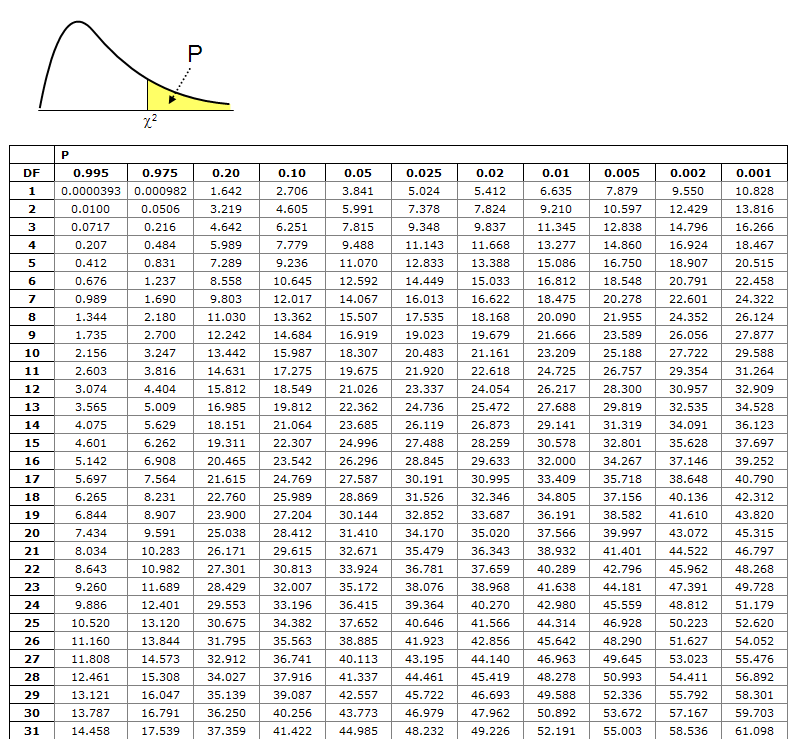

# Apendice

In [273]:
#@title Grafico auxiliar


# Creamos la figura en Bokeh (es como matplotlib)
p = figure(title='Distribucion de chi-cuadrado con {} grados de libertad'.format(grados_libertad),
           x_axis_label='Valor de chi-cuadrado',
           y_axis_label='Densidad de probabilidad', height=400, width=800)

# Ploteamos la distribucion de chi-cuadrado
p.line(rango_x, pdf, line_width=2)

# Linea vertical para el valor del chi-cuadrado obtenido
vline_chi2obtenido = Span(location=chi_cuadrado, dimension='height', line_color='red', line_width=2)
p.add_layout(vline_chi2obtenido)

# Linea vertical para el valor del chi-cuadrado teorico
vline_chi2teorico = Span(location=grados_libertad, dimension='height', line_color='black', line_width=1)
p.add_layout(vline_chi2teorico)

# Lineas verticales para la desviacion estandar teorica de chi-cuadrado
vline_sigmachi2_1 = Span(location=grados_libertad-np.sqrt(grados_libertad), dimension='height', line_color='black', line_width=1, line_dash='dashed')
vline_sigmachi2_2 = Span(location=grados_libertad+np.sqrt(grados_libertad), dimension='height', line_color='black', line_width=1, line_dash='dashed')
p.add_layout(vline_sigmachi2_1)
p.add_layout(vline_sigmachi2_2)

# Area bajo la curva a partir del valor de chi-cuadrado
rango_tail = np.linspace(chi_cuadrado, np.max(rango_x), 1000)
pdf_tail = stats.chi2.pdf(rango_tail, grados_libertad)
p.varea(x=rango_tail, y1=pdf_tail, y2=0, fill_color="blue", fill_alpha=0.2)

# Mostramos la figura
show(p)